<a href="https://colab.research.google.com/github/rmit-ir/Tutotrial-Practical-LLMs/blob/main/LLM_OpenRouter_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import the necessary packages

In [1]:
%pip install ir_datasets
%pip install krippendorff

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.9 MB/s eta 0:00:00
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18920 sha256=71e665503f7d9b43d78187cf70c45867c89b0813ef58fd3a2737b58549c63c74
  Stored in directory: /root/.cache/pip/wheels/63/f9/dc/2dd16d3330e327236e4d407941975c42d5159d200cdb7922d8
  Created wheel for cbor: filename=cbor-1.0.0-cp311-cp311-linux_x86_64.whl size=53928 sha256=8ac1cf5666761051753019a2e79cb4e0462ac77b12c39375fdf8c5bc774a581c
  Stored in directory: /root/.cache/pip/wheels/21/6b/45/0c34253b1af07d1d9dc524f6d44d74a6b191c43152e6aaf641
Successfully built warc3-wet-clueweb09 cbor


In [ ]:
import requests
import json
import pandas as pd
import ir_datasets
import krippendorff
import re
import textwrap
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import userdata

In [ ]:
VERBOSE = 0  # 0: no output, 1: some output, 2: all output

# set line wrap for print, lower for smaller screens
WRAP = 100
printw = lambda x: print(textwrap.fill(x, WRAP))

# Load the first dataset and print some basic stats

[INFO] Please confirm you agree to the authors' data usage agreement found at <https://ciir.cs.umass.edu/downloads/Antique/readme.txt>
[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/test-queries-blacklist.txt


Number of documents in Antique/test/non-offensive dataset: 403,666
Number of queries in Antique/test/non-offensive dataset: 176
Number of qrels in full Antique/test/non-offensive dataset: 5,752


[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/test-queries-blacklist.txt: [00:00] [184B] [749kB/s]
[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt: [00:00] [11.4kB] [1.81MB/s]
[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test.qrel
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test.qrel: [00:00] [150kB] [4.11MB/s]



 --*----*----*----*----*----*----*----*----*----*----*----*----*----*----*-- 

For this example we select only the first 20 queries
For this example we sample only 5 documents per query
Number of queries after filtering: 20
Number of qrels after filtering: 100

 --*----*----*----*----*----*----*----*----*----*----*----*----*----*----*-- 

Queries DF:
                                                       text
query_id                                                   
1287437                  how can i lose 30 pounds by june3?
1351675   Why must I have an uncracked winshield in orde...
1702151                       How patient a driver are you?
1783010                                  What is Blaphsemy?
1844896                          How to cook Angus burgers?
1880028   What does "see Leaflet" mean on Ept Pregnancy ...
2142044   What do you speculate happened to Natalie Holl...
2484180    why do people judge a dog by what he looks like?
2528767   How do I determine the charge of the

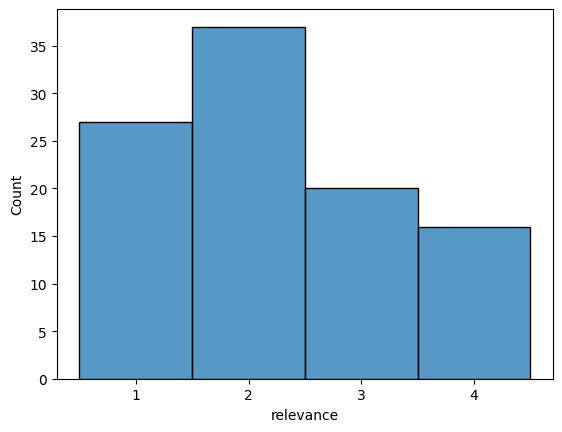

,count
relevance,
1,27
2,37
3,20
4,16


In [ ]:
collection_id = "antique/test/non-offensive"
dataset = ir_datasets.load(collection_id)
docstore = dataset.docs_store()

print(
    f"Number of documents in {collection_id.capitalize()} dataset: {dataset.docs_count():,d}"
)
print(
    f"Number of queries in {collection_id.capitalize()} dataset: {dataset.queries_count():,d}"
)
print(
    f"Number of qrels in full {collection_id.capitalize()} dataset: {dataset.qrels_count():,d}"
)

queries_df = pd.DataFrame(dataset.queries_iter()).set_index("query_id")
queries_df.index = queries_df.index.astype(str)
qrels_df = pd.DataFrame(dataset.qrels_iter())

print("\n", "--*--" * 15, "\n")
qn = 20
print(f"For this example we select only the first {qn} queries")
queries_df = queries_df[:qn]
qrels_df = qrels_df.loc[qrels_df["query_id"].isin(queries_df.index)]

dn = 5
print(f"For this example we sample only {dn} documents per query")
qrels_df = qrels_df.groupby("query_id").sample(n=dn, replace=False, random_state=2703)

print(f"Number of queries after filtering: {len(queries_df)}")
print(f"Number of qrels after filtering: {len(qrels_df)}")

print("\n", "--*--" * 15, "\n")
print("Queries DF:")
print(queries_df.sort_index())

print("\n", "--*--" * 15, "\n")
print("Qrels DF:")
print(qrels_df)

print("\n", "--*--" * 15, "\n")
qrels_def = "".join(
    [textwrap.fill(f"{k}: {v}", WRAP) + "\n" for k, v in dataset.qrels_defs().items()]
)
print("Qrels definitions:\n")
print(qrels_def)

# Check the range of relevance values
min_rel = qrels_df["relevance"].min()
max_rel = qrels_df["relevance"].max()
print(f"Min relevance: {min_rel}, Max relevance: {max_rel}\n")

# Plot the distribution of relevance values
sns.histplot(
    qrels_df.sort_values("relevance").astype(str), x="relevance", discrete=True
)
plt.show()

qrels_df["relevance"].value_counts().sort_index()

In [ ]:
# Print one random relevance judgment from Qrels
print("\n", "--*--" * 15, "\n")
random_qrel_row = qrels_df.sample(n=1, random_state=2703)
print(f"Random row from qrels:\n{random_qrel_row}")
qid, doc_id, relevance, _ = random_qrel_row.to_numpy()[0]

print(f"The relevance of document {doc_id} to query {qid} is: {relevance}")

# Print the query and document from the relevance judgment
print("\n", "--*--" * 15, "\n")
print(f"Query {qid}:")
print(queries_df.loc[qid, "text"], "\n")

doc = docstore.get(doc_id)
print(f"Document {doc.doc_id}:")
printw(f"Document's text:\n{doc.text}")

[INFO] [starting] building docstore



 --*----*----*----*----*----*----*----*----*----*----*----*----*----*----*-- 

Random row from qrels:
    query_id    doc_id  relevance iteration
863  4448097  827475_3          1        Q0
The relevance of document 827475_3 to query 4448097 is: 1

 --*----*----*----*----*----*----*----*----*----*----*----*----*----*----*-- 

Query 4448097:
what is innate immunity? 



[INFO] If you have a local copy of https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/684f7015aff377062a758e478476aac8
[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt
docs_iter:   0%|                                    | 0/403666 [00:00<?, ?doc/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.0%| 0.00/93.6M [00:00<?, ?B/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 2.1%| 1.97M/93.6M [00:00<00:04, 19.5MB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 11.7%| 10.9M/93.6M [00:00<00:01, 54.2MB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 21.2%| 19.8M/93.6M [00:00<00:01, 62.7MB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 30.8%| 28.8M/93.6M [00:00<00:00, 66.3MB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 40

Document 827475_3:
Document's text: I believe that being cold lowers your immune system and since your immune system is
what you need to fight colds, you are at higher risk for catching something when it is cold outside
and you have a lot of exposure to those elements.


# Create instructions prompts
Create a relevance judgment prompt template. The prompt is a template that will
be filled with the query and document text. Note using an f-string with `{variable}` that will be filled
immediately, and `{{variable}}` that will be filled in later. The prompt template should look like this:
```python
prompt_template = """
You are [...]
Query: {query}
Document: {document}
"""
```

In [ ]:
_prompt = f"""Judge the relevance of the following document to the given query.
Output a relevance score based on the following scale:

{qrels_def}
If the document is completely irrelevant to the query, output {min_rel}.
Otherwise, output a relevance score between {int(min_rel) + 1} and {max_rel}.

The response should be a single number between {min_rel} and {max_rel}.
Provide only a single score without any additional text.

Query:
{{query}}

Document:
{{document}}
"""
print("Prompt template:")
print(_prompt)

print("\n", "--*--" * 15, "\n")
print("An example of the prompt with a query and document:")
printw(
    _prompt.format(
        query=queries_df.iloc[0, 1], document=docstore.get(qrels_df.iloc[0].doc_id).text
    )
)

Judge the relevance of the following document to the given query.
Output a relevance score based on the following scale:

4: It looks reasonable and convincing. Its quality is on parwith or better than the "Possibly
Correct Answer". Note that it does not have to provide the same answer as the "PossiblyCorrect
Answer".
3: It can be an answer to the question, however, it is notsufficiently convincing. There should be
an answer with much better quality for the question.
2: It does not answer the question or if it does, it provides anunreasonable answer, however, it is
not out of context. Therefore, you cannot accept it as an answer to the question.
1: It is completely out of context or does not make any sense.

If the document is completely irrelevant to the query, output 1.
Otherwise, output a relevance score between 2 and 4.

The response should be a single number between 1 and 4.
Provide only a single score without any additional text.

Query:
{query}

Document:
{document}



# Define functions for model api calls and response parsing

In [ ]:
def get_response(prompt: str, model: str, verbose: int = VERBOSE) -> dict:
    """
    Get a response from the OpenRouter API using the given prompt and model.
    Make sure to set your OpenRouter API key in the environment variable
    OPENROUTER_API_KEY. OpenRouter normalizes requests and responses across
    providers. That is, you can use the same code to call different models from
    different providers.
    Args:
        prompt (str): The prompt to send to the model.
        model (str): The model to use.
        verbose (int): Verbosity level for debugging.
    Returns:
        dict: The response from the model.
    """
    messages = [{"role": "user", "content": prompt}]

    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={"Authorization": f"Bearer {userdata.get('OPENROUTER_API_KEY')}"},
        data=json.dumps(
            {
                "model": model,
                "messages": messages,
                "top_p": 1,
                "temperature": 0.9,
                "frequency_penalty": 0,
                "presence_penalty": 0,
                "repetition_penalty": 1,
                "top_k": 0,
            }
        ),
    )
    if verbose > 0:
        print(f"Response status code: {response.status_code}")
    response_json = response.json()
    # let's print how many tokens we used, it can be useful for cost estimation
    if verbose > 0:
        print(f"Response usage: {response_json.get('usage')}")
    return response_json


def parse_answer_from_text(text: str, verbose: int = VERBOSE) -> str:
    """
    Parse the answer from the text returned by the model.
    The function looks for digits in the text and returns the last one found.
    If there are multiple digits, it tries to extract the first score
    window of up to 5 terms after the word "score".
    If no digits are found, it returns an empty string.
    Args:
        text (str): The text to parse.
        verbose (int): Verbosity level for debugging.
    Returns:
        str: The parsed answer.
    """
    score = ""
    all_digits = re.findall(r"\d+", text)
    if all_digits:
        score = all_digits[-1]
    else:
        if verbose > 0:
            print("Couldn't parse any digits from the response")
            print(f"all_digits: {all_digits}")
            print(f"Text: {text} \nEnd of Text\n")
            print("\n", "-=return=-" * 10, "\n")
        return ""
    if len(all_digits) > 1:
        # if multiple digits try to extract the first score
        # window of up to 5 terms after the "score"
        try:
            score_window = " ".join(text.lower().split("score")[-1].split()[:5])
            score = re.findall(r"\d+", score_window)[0]
            if verbose > 1:
                print(f"Text: {text} \nEnd of Text\n")
                print(f"score_window: {score_window}")
        except IndexError:
            if verbose > 0:
                print("Couldn't find score window")
                print(f"Text: {text} \nEnd of Text\n")
    # print(f'All digits: {all_digits}')
    # print(f'Extracted Score: {score}')
    # print('\n', '-=return=-' * 10, '\n')
    return score

# Generate the relevance predictions for the first dataset

In [ ]:
# Available models in OpenRouter
# Models are categorized as free (marked with ":free") or paid with varying pricing
# Models may change over time - check current availability and pricing at:
# https://openrouter.ai/models
# Note: Different models have varying token limits and optimal hyperparameter settings

MODEL = {
    "llama-free": "meta-llama/llama-3.3-70b-instruct:free",
    "deepseek-r1-free": "deepseek/deepseek-r1-distill-llama-70b:free",
    "deepseek-r1-qwen": "deepseek/deepseek-r1-distill-qwen-1.5b",
    "gemini-flash-2": "google/gemini-2.0-flash-001",
    "gemini-pro-2": "google/gemini-2.0-pro-exp-02-05:free",
    "gemini-flash-2free": "google/gemini-2.0-flash-exp:free",
    "gemma-3-4b": "google/gemma-3-4b-it:free",
    "llama-3.2-1b": "meta-llama/llama-3.2-1b-instruct",
    "gpt-4o-mini": "openai/gpt-4o-mini",
}


def generate_relevance_predictions(
    qrel_df: pd.DataFrame,
    docs,
    query_df: pd.DataFrame,
    prompt: str,
    model: str,
    verbose: int = VERBOSE,
) -> tuple:
    """
    Generate relevance predictions using the OpenRouter API.
    Args:
        qrel_df (DataFrame): The qrel DataFrame.
        docs (DataFrame or Lz4FullStore): The document store.
        query_df (DataFrame): The query DataFrame.
        prompt (str): The prompt template.
        model (str): The model to use.
        verbose (int): Verbosity level for debugging.
    Returns:
        dict: The relevance predictions.
        dict: The reasoning results.
        list: The raw responses from the model.
    """
    results = {}
    reasoning_results = {}
    raw_responses = []  # for debugging, logging and backup

    for index, row in qrel_df.iterrows():
        qid, doc_id = row["query_id"], row["doc_id"]
        if isinstance(docs, ir_datasets.indices.lz4_pickle.PickleLz4FullStore):
            doc = docs.get(doc_id)
        else:
            doc = docs.loc[doc_id]
        prompt_text = prompt.format(
            query=query_df.loc[qid, "text"], document=doc.text
        )  # adding a query and document to the prompt
        if verbose > 0:
            print(f"Running for {qid, doc_id}")
            if verbose > 1:
                print(f"Prompt for {qid, doc_id}:")
                printw(prompt_text)
        response_json = get_response(prompt_text, model, verbose=verbose)
        raw_responses.append(response_json)
        response_message = response_json.get("choices", {0: {"message": None}})[0][
            "message"
        ]
        if response_message is None:
            print(f"No response message for {qid, doc_id}")
            print(response_json.get("error"))
            continue
        if verbose > 1:
            print(f"Response for {qid, doc_id}:")
            printw(f"Response message: {response_message}")
            print("\n", "-=" * 5, " End of response ", "=-" * 5, "\n")
        response_content = response_message.get("content", None)
        reasoning_results[qid, doc_id] = response_message.get("reasoning", None)
        results[qid, doc_id] = response_content
    return results, reasoning_results, raw_responses

In [ ]:
# Run the model for the first time
# Note: This takes ~2 minutes
first_results, first_reasoning_results, first_raw_responses = (
    generate_relevance_predictions(
        qrels_df,
        docstore,
        queries_df,
        _prompt,
        model=MODEL["llama-3.2-1b"],
    )
)

In [ ]:
def compute_total_tokens_used(raw_responses: list) -> tuple:
    """
    Compute the total number of tokens used in the responses.
    Args:
        raw_responses (list): The raw responses from the model.
    Returns:
        tuple: The total number of input, output, and total tokens used.
    """
    total_input_tokens = sum(
        [response_json["usage"]["prompt_tokens"] for response_json in raw_responses]
    )
    print(f"Total input tokens used: {total_input_tokens:,d}")
    total_output_tokens = sum(
        [response_json["usage"]["completion_tokens"] for response_json in raw_responses]
    )
    print(f"Total output tokens used: {total_output_tokens:,d}")
    total_tokens = sum(
        [response_json["usage"]["total_tokens"] for response_json in raw_responses]
    )
    print(f"Total tokens used: {total_tokens:,d}")
    return total_input_tokens, total_output_tokens, total_tokens


compute_total_tokens_used(first_raw_responses)

Total input tokens used: 30,950
Total output tokens used: 135
Total tokens used: 31,085


(30950, 135, 31085)

# Evaluate the relevance judgments of the first dataset

In [ ]:
def parse_results_to_df(
    results: dict, reasoning_results=None, scores_range=(-1, 4), verbose: int = VERBOSE
) -> pd.DataFrame:
    """
    Parse the results from the model into a DataFrame.
    Args:
        results (dict): The results from the model.
        reasoning_results (dict): The reasoning results from the model.
        scores_range (tuple): The range of scores to use.
        verbose (int): Verbosity level for debugging.
    Returns:
        DataFrame: The parsed results as a DataFrame.
    """
    min_score, max_score = scores_range
    p_df = pd.DataFrame.from_dict(results, orient="index")
    p_df.index = pd.MultiIndex.from_tuples(p_df.index)
    p_df.index.names = ["query_id", "doc_id"]
    p_df.columns = ["predicted"]
    p_df["predicted"] = p_df["predicted"].apply(parse_answer_from_text, args=[verbose])

    if reasoning_results is not None:
        # fill empty predictions from the reasoning field in raw responses
        for index, row in p_df.loc[p_df["predicted"] == ""].iterrows():
            qid, doc_id = index
            if verbose > 1:
                print(f"Empty prediction for {qid, doc_id}")
                print(f"Raw response text: {results[qid, doc_id]}\n")
            if reasoning_results[qid, doc_id] is not None:
                p_df.loc[index, "predicted"] = parse_answer_from_text(
                    reasoning_results[qid, doc_id], verbose=verbose
                )
            else:
                if verbose > 0:
                    print(f"No response or reasoning for: {qid, doc_id}")
                    print(f"Setting min score: {min_score}")
                p_df.loc[index, "predicted"] = str(min_score)

    p_df.loc[p_df["predicted"].isin({"", 0, "0", None})] = str(min_score)
    return p_df.astype(int).clip(lower=min_score, upper=max_score)


first_predictions_df = parse_results_to_df(
    first_results, first_reasoning_results, scores_range=(min_rel, max_rel)
)

Shape of merged df: (100, 5)


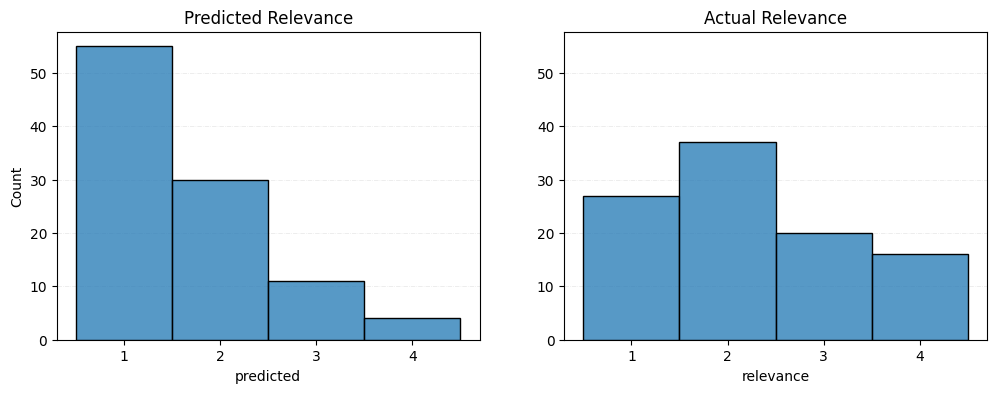

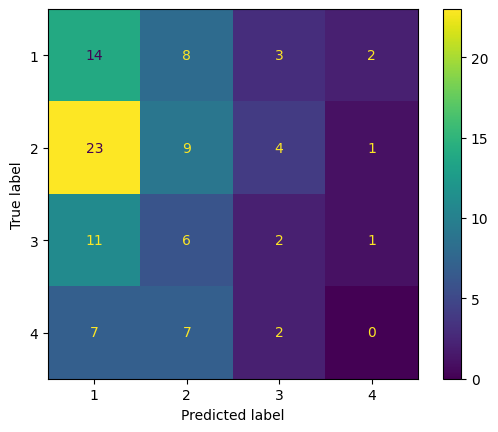



Krippendorff's alpha: -0.10
Spearman's correlation: 0.01
------------------------------ Binary Relevance Eval ------------------------------


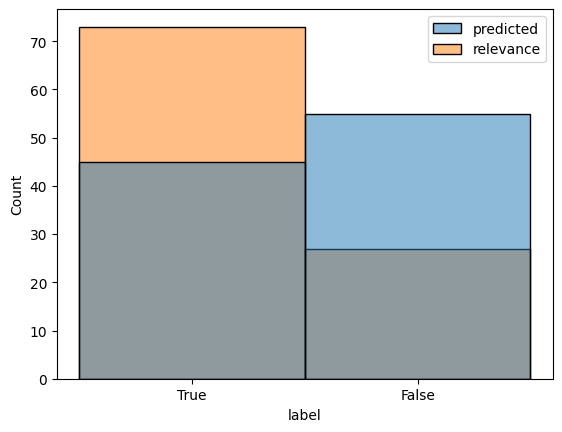

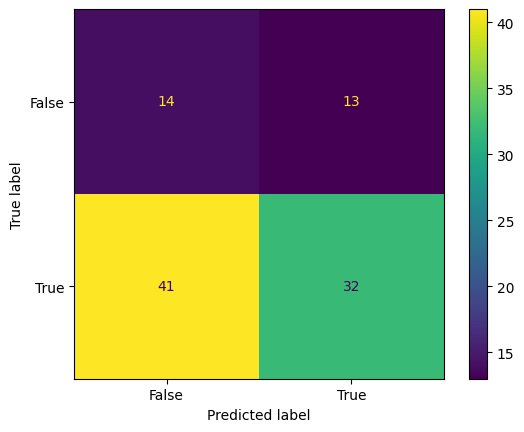



Krippendorff's alpha: -0.11


,predicted,query_id,doc_id,relevance,iteration
1279,1,1351675,2720201_4,1,Q0
2068,1,1702151,388224_10,1,Q0
221,1,1844896,1854996_2,1,Q0
1219,1,2814599,3483686_5,1,Q0
1677,1,2956570,186445_0,1,E0
...,...,...,...,...,...
1440,3,714612,714612_5,4,Q0
1679,4,2956570,948766_0,1,E0
4987,4,3698636,478952_14,1,Q0
106,4,1880028,4145479_0,2,Q0


In [ ]:
def evaluate_relevance_predictions(
    predictions_df: pd.DataFrame, qrel_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Evaluate relevance predictions against ground truth qrels data.

    This function compares predicted relevance scores with actual relevance judgments,
    providing several evaluation metrics including confusion matrices, Krippendorff's alpha,
    and Spearman's correlation. It also evaluates binary relevance classification.

    Args:
        predictions_df (pd.DataFrame): DataFrame with predicted relevance scores.
            Expected to have MultiIndex of (query_id, doc_id) and a 'predicted' column.
        qrel_df (pd.DataFrame): Ground truth relevance judgments DataFrame.
            Expected to have columns 'query_id', 'doc_id', and 'relevance'.

    Returns:
        pd.DataFrame: Merged DataFrame containing both predicted and actual relevance scores,
                     sorted by predicted scores and actual relevance.

    Visualizes:
        - Histograms comparing predicted vs. actual relevance distributions
        - Confusion matrix of relevance scores
        - Binary relevance evaluation (relevant if score > 1)

    Metrics:
        - Krippendorff's alpha for both ordinal and binary relevance
        - Spearman's rank correlation coefficient
    """

    merged_df = pd.merge(
        predictions_df,
        qrel_df,
        left_index=True,
        right_on=["query_id", "doc_id"],
        how="inner",
    )
    print(f"Shape of merged df: {merged_df.shape}")

    # Convert the relevance scores to numeric, handling potential errors.
    try:
        merged_df["relevance"] = pd.to_numeric(merged_df["relevance"])
        merged_df["predicted"] = pd.to_numeric(merged_df["predicted"])
    except ValueError as e:
        print(f"Error converting relevance scores to numeric: {e}")
        # Handle the error appropriately, e.g., by removing rows with invalid scores or assigning default values.
        # For example, you could remove the invalid rows:
        # merged_df = merged_df[pd.to_numeric(merged_df['relevance_x'], errors='coerce').notna()]
        # merged_df = merged_df[pd.to_numeric(merged_df['relevance_y'], errors='coerce').notna()]

    min_score, max_score = merged_df["relevance"].min(), merged_df["relevance"].max()
    # plot two histograms side by side of predicted values and actual relevance values
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    sns.histplot(
        merged_df["predicted"].sort_values().astype(str),
        ax=axs[0],
        discrete=True,
        zorder=10,
    )
    axs[0].set_title("Predicted Relevance")
    sns.histplot(
        merged_df["relevance"].sort_values().astype(str),
        ax=axs[1],
        discrete=True,
        zorder=10,
    )
    axs[1].set_title("Actual Relevance")
    # Add grid lines  on y axis
    axs[0].grid(
        axis="y",
        which="major",
        color="gray",
        alpha=0.2,
        linestyle="-.",
        linewidth=0.5,
        zorder=1,
    )
    axs[1].grid(
        axis="y",
        which="major",
        color="gray",
        alpha=0.2,
        linestyle="-.",
        linewidth=0.5,
        zorder=1,
    )

    # show tick labels on y axis
    axs[1].yaxis.set_tick_params(labelleft=True)

    plt.show()
    print("\n")

    # plot a confusion matrix
    cm = confusion_matrix(merged_df["relevance"], merged_df["predicted"])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=np.sort(merged_df["relevance"].unique())
    )
    disp.plot()
    plt.show()
    print("\n")

    # Compute Krippendorff's alpha. reliability_data expects an array or df where the coders are rows and units are columns
    alpha = krippendorff.alpha(
        reliability_data=merged_df[["relevance", "predicted"]].T,
        level_of_measurement="ordinal",
    )
    print(f"Krippendorff's alpha: {alpha:.2f}")

    # Compute Spearman's correlation
    spearman_corr = merged_df["relevance"].corr(
        merged_df["predicted"], method="spearman"
    )
    print(f"Spearman's correlation: {spearman_corr:.2f}")

    print("---" * 10, "Binary Relevance Eval", "---" * 10)
    bi_relevance_df = merged_df[["predicted", "relevance"]].map(
        lambda x: True if x > 1 else False
    )
    sns.histplot(
        data=bi_relevance_df.stack()
        .reset_index()
        .rename(columns={"level_1": "", 0: "label"})
        .astype(str),
        x="label",
        hue="",
        discrete=True,
    )
    plt.show()
    print("\n")

    bi_relevance_df.value_counts().to_frame().pivot_table(
        index="predicted", columns="relevance"
    )
    cm = confusion_matrix(bi_relevance_df["relevance"], bi_relevance_df["predicted"])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=np.sort(bi_relevance_df["relevance"].unique()),
    )
    disp.plot()
    plt.show()
    print("\n")

    # Compute Krippendorff's alpha. reliability_data expects an array or df where the coders are rows and units are columns
    alpha = krippendorff.alpha(
        reliability_data=bi_relevance_df[["relevance", "predicted"]].T.astype(int),
        level_of_measurement="nominal",
    )

    print(f"Krippendorff's alpha: {alpha:.2f}")

    return merged_df.sort_values(by=["predicted", "relevance"])


evaluate_relevance_predictions(first_predictions_df, qrels_df)

# Quick Summary
## We've defined the following utility functions:
1. [get_response, parse_answer_from_text](#scrollTo=7LReDtNrqFxN&line=3&uniqifier=1)
2. [compute_total_tokens_used](#scrollTo=IFOQQebOzwzB&line=1&uniqifier=1)
3. [parse_results_to_df](#scrollTo=ZCnDdNPBJ4Qp&line=1&uniqifier=1)

## And the following processing functions:
1. [generate_relevance_predictions](#scrollTo=HQbxDjtnOTuz&line=8&uniqifier=1)
2. [evaluate_relevance_predictions](#scrollTo=Gr_tg02FLEkE&line=4&uniqifier=1)


## Next, we'll load a new dataset and apply these functions on new data




# Loading and predicting the LLM4EVal dataset
## https://llm4eval.github.io/LLMJudge-benchmark/#
### based on data from TREC-DL 2023

In [13]:
# clone the GitHub repo locally
!git clone https://github.com/llm4eval/LLMJudge.git

Cloning into 'LLMJudge'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 83 (delta 38), reused 41 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 2.44 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (38/38), done.


Sampling 10 documents per query
Number of selected queries in TREC dataset: 15
Number of selected qrels in TREC dataset: 150
Min relevance: 1, Max relevance: 4

Relevance definitions:
[3] Perfectly relevant: The passage is dedicated to the query and contains the exact answer.
[2] Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
[1] Related: The passage seems related to the query but does not answer it.
[0] Irrelevant: The passage has nothing to do with the query.



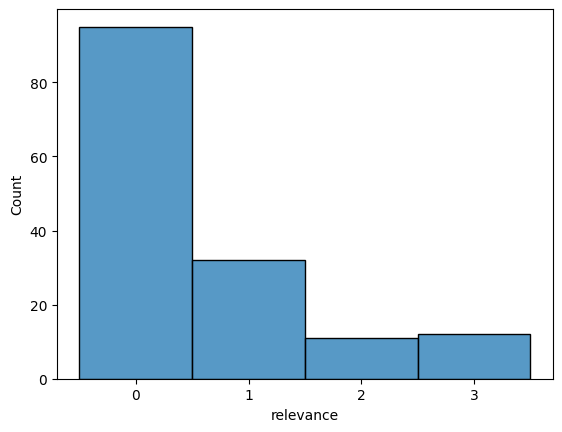

,query_id,doc_id,relevance
2710,q10,p4056,3
3076,q10,p351,1
3235,q10,p9010,3
3029,q10,p2256,1
2701,q10,p453,1
...,...,...,...
1846,q8,p11521,2
1988,q8,p2350,2
2105,q8,p4964,0
2003,q8,p8928,1


In [ ]:
trec_docs_df = (
    pd.read_json("LLMJudge/data/llm4eval_document_2024.jsonl", lines=True)
    .rename(columns={"docid": "doc_id", "doc": "text"})
    .set_index("doc_id")
)
trec_queries_df = pd.read_csv(
    "LLMJudge/data/llm4eval_query_2024.txt",
    sep="\t",
    header=None,
    names=["query_id", "text"],
).set_index("query_id")
trec_qrels_df = pd.read_csv(
    "LLMJudge/data/llm4eval_dev_qrel_2024.txt",
    sep="\s+",
    header=None,
    names=["query_id", "iteration", "doc_id", "relevance"],
).drop(columns="iteration")


# select first qn queries
qn = 15
first_n_qids = trec_qrels_df["query_id"].unique()[:qn]
trec_queries_df = trec_queries_df.loc[first_n_qids]
trec_qrels_df = trec_qrels_df.loc[trec_qrels_df["query_id"].isin(first_n_qids)]

# sample dn documents per query
dn = 10
print(f"Sampling {dn} documents per query")
trec_qrels_df = trec_qrels_df.groupby("query_id").sample(
    n=dn, replace=False, random_state=2703
)

print(f"Number of selected queries in TREC dataset: {len(trec_queries_df)}")
print(f"Number of selected qrels in TREC dataset: {len(trec_qrels_df)}")

trec_min_rel = trec_qrels_df["relevance"].min()
trec_max_rel = trec_qrels_df["relevance"].max()
print(f"Min relevance: {min_rel}, Max relevance: {max_rel}\n")
print(
    """Relevance definitions:
[3] Perfectly relevant: The passage is dedicated to the query and contains the exact answer.
[2] Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
[1] Related: The passage seems related to the query but does not answer it.
[0] Irrelevant: The passage has nothing to do with the query.\n"""
)

sns.histplot(
    trec_qrels_df.sort_values("relevance").astype(str),
    x="relevance",
    discrete=True,
    binrange=(trec_min_rel, trec_max_rel),
)
plt.show()

trec_qrels_df["relevance"].value_counts()

trec_qrels_df.loc[trec_qrels_df["query_id"].isin(first_n_qids)]

In [ ]:
# define TREC instructions prompt

first_prompt = f"""Judge the relevance of the below document to the given query.
Output a relevance score based on the following scale:
[3] Perfectly relevant: The passage is dedicated to the query and contains the exact answer.
[2] Highly relevant: The passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information.
[1] Related: The passage seems related to the query but does not answer it.
[0] Irrelevant: The passage has nothing to do with the query.

The response should be a single number between {trec_min_rel} and {trec_max_rel}.

The thought process should be first to decide whether the document is relevant or not,
if not, assign it a {trec_min_rel}.
Otherwise decide how relevant the document is to the query, based on that assign a score between {int(trec_min_rel) + 1} and {trec_max_rel}.
{trec_max_rel} should be assigned only to perfectly relevant documents.

Provide only a single score without any additional text.

Query:
{{query}}

Document:
{{document}}
"""


umbrella_prompt = f"""Given a query and a passage, you must provide a score on an integer scale of {trec_min_rel} to {trec_max_rel} with the
following meanings:

0 = represent that the passage has nothing to do with the query,
1 = represents that the passage seems related to the query but does not answer it,
2 = represents that the passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous
information and
3 = represents that the passage is dedicated to the query and contains the exact answer.

Important Instruction: Assign category 1 if the passage is somewhat related to the topic but not completely,
category 2 if the passage presents something very important related to the entire
topic but also has some extra information and category {trec_max_rel} if the passage only and entirely refers to
the topic. If none of the above satisfies give it category {trec_min_rel}.

Query: {{query}}
Passage: {{document}}

Split this problem into steps: Consider the underlying intent of the search. Measure how well the content
matches a likely intent of the query (M). Measure how trustworthy the passage is (T). Consider the
aspects above and the relative importance of each, and decide on a final score (O).

Final score must be an integer value only. Do not provide any code in the result.
Provide each score in the format of:
##final score: score without providing any reasoning.
"""
print(umbrella_prompt)

Given a query and a passage, you must provide a score on an integer scale of 0 to 3 with the
following meanings: 

0 = represent that the passage has nothing to do with the query,
1 = represents that the passage seems related to the query but does not answer it, 
2 = represents that the passage has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous
information and 
3 = represents that the passage is dedicated to the query and contains the exact answer.

Important Instruction: Assign category 1 if the passage is somewhat related to the topic but not completely,
category 2 if the passage presents something very important related to the entire
topic but also has some extra information and category 3 if the passage only and entirely refers to
the topic. If none of the above satisfies give it category 0.  

Query: {query}
Passage: {document}

Split this problem into steps: Consider the underlying intent of the search. Measure how well the content
ma

In [ ]:
# Generate predictions for the TREC data - Takes 2 minutes for 150 query doc pairs
trec_results, trec_reasoning_results, trec_raw_responses = (
    generate_relevance_predictions(
        trec_qrels_df,
        trec_docs_df,
        trec_queries_df,
        prompt=first_prompt,
        model=MODEL["llama-3.2-1b"],
    )
)

In [17]:
compute_total_tokens_used(trec_raw_responses)

Total input tokens used: 56,413
Total output tokens used: 236
Total tokens used: 56,649


(56413, 236, 56649)

In [ ]:
trec_predictions_df = parse_results_to_df(
    trec_results,
    trec_reasoning_results,
    scores_range=(trec_min_rel, trec_max_rel),
)
trec_predictions_df

predicted
query_id doc_id           
q10      p4056           0
         p351            0
         p9010           1
         p2256           0
         p453            2
...                    ...
q8       p11521          0
         p2350           0
         p4964           0
         p8928           0
         p6001           1

[150 rows x 1 columns]

Shape of merged df: (150, 4)


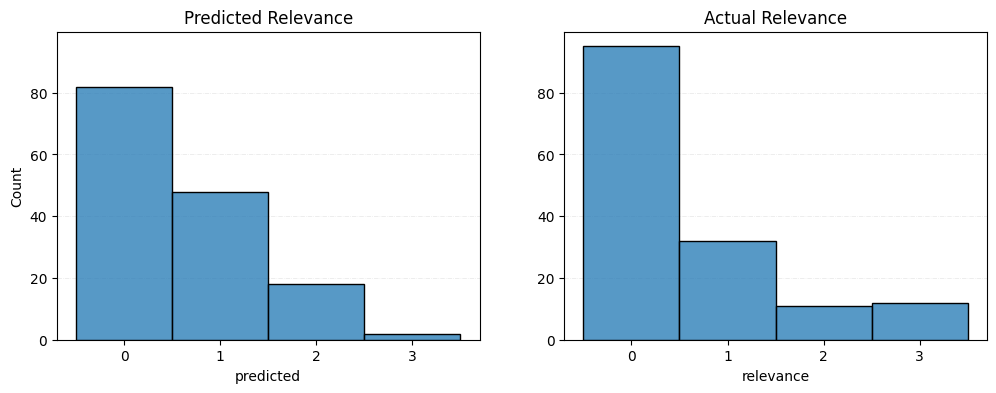

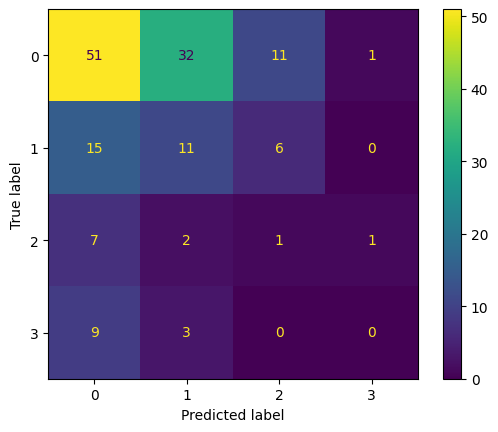



Krippendorff's alpha: -0.05
Spearman's correlation: -0.05
------------------------------ Binary Relevance Eval ------------------------------


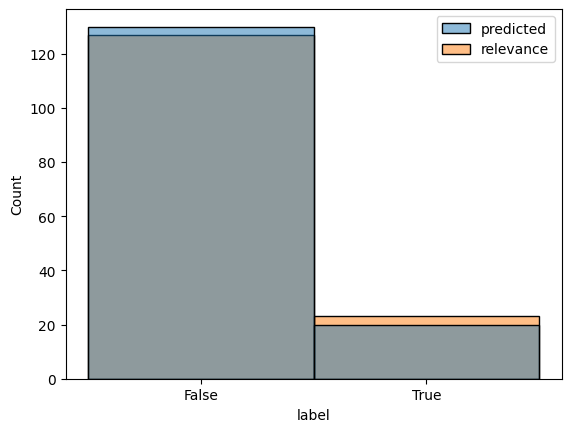

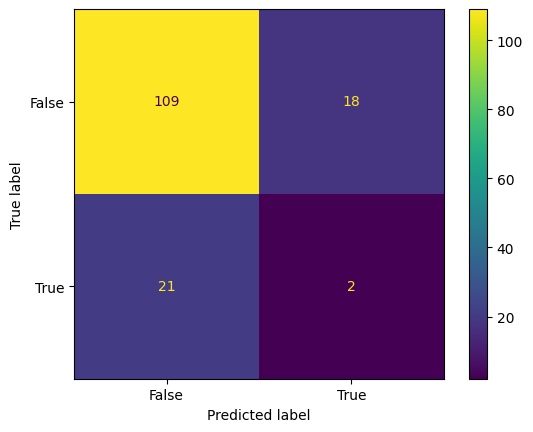



Krippendorff's alpha: -0.06


In [ ]:
# Evaluate the predictions for the TREC data
trec_eval_df = evaluate_relevance_predictions(
    trec_predictions_df, trec_qrels_df
).set_index(["query_id", "doc_id"])

In [ ]:
# print a disagreement
qid, docid = (
    trec_eval_df.loc[
        (trec_eval_df["predicted"] == trec_min_rel)
        & (trec_eval_df["relevance"] == trec_max_rel)
    ]
    .sample(n=1)
    .index[0]
)
print(
    f"The following pair has relevance scores of:\n{trec_eval_df.loc[(qid, docid), ['relevance', 'predicted']]}\n"
)
print(f'Query: {trec_queries_df.loc[qid, "text"]}')
printw(f'Document: {trec_docs_df.loc[docid, "text"]}')

The following pair has relevance scores of:
relevance    3
predicted    0
Name: (q10, p4056), dtype: int64

Query: why do pilots purposely fly low
Document: The pilot had been flying at treetop level to avoid radar detection, but such low-flying
planes were more vulnerable to small arms. U.S. planes targeted Hanoi industrial sites, but most
industries were relocated to the countryside. Image: Doan Cong Tinh/Another Vietnam/National
Geographic Books. 1972.


In [ ]:
# test with 'gemini-flash-2' takes 3 minutes
trec_results_2, trec_reasoning_results_2, trec_raw_responses_2 = (
    generate_relevance_predictions(
        trec_qrels_df,
        trec_docs_df,
        trec_queries_df,
        prompt=umbrella_prompt,
        model=MODEL["gemini-flash-2"],
    )
)

In [25]:
compute_total_tokens_used(trec_raw_responses_2)

Total input tokens used: 67,281
Total output tokens used: 2,606
Total tokens used: 69,887


(67281, 2606, 69887)

In [ ]:
trec_predictions_df_2 = parse_results_to_df(
    trec_results_2,
    trec_reasoning_results_2,
    scores_range=(trec_min_rel, trec_max_rel),
)
trec_predictions_df_2

predicted
query_id doc_id           
q10      p4056           2
         p351            1
         p9010           2
         p2256           0
         p453            2
...                    ...
q8       p11521          3
         p2350           3
         p4964           0
         p8928           3
         p6001           3

[150 rows x 1 columns]

Shape of merged df: (150, 4)


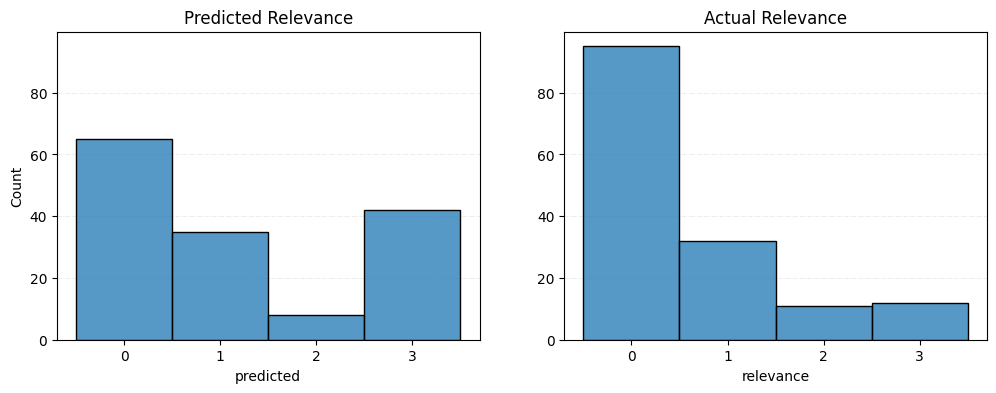

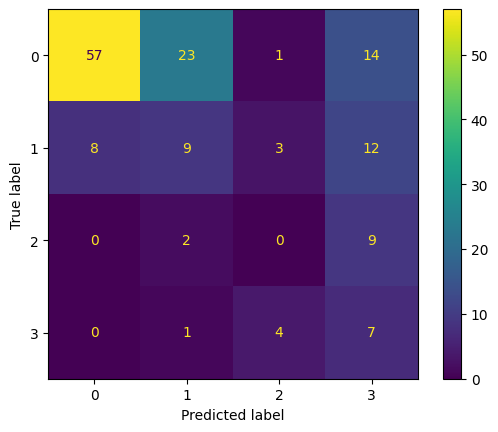



Krippendorff's alpha: 0.44
Spearman's correlation: 0.53
------------------------------ Binary Relevance Eval ------------------------------


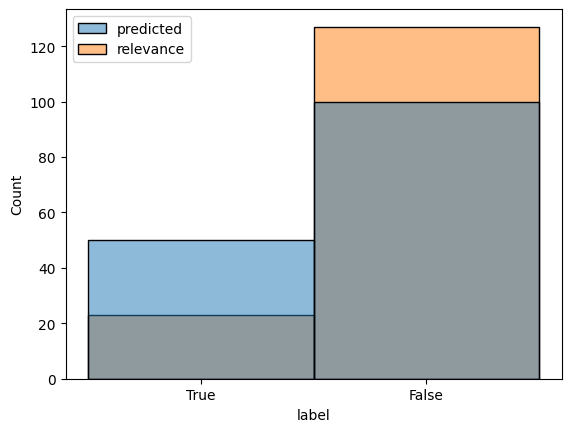

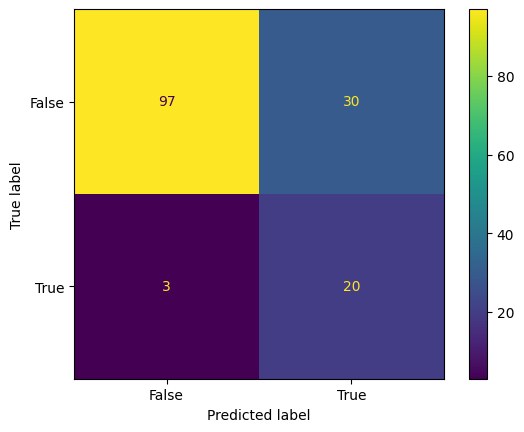



Krippendorff's alpha: 0.40


In [ ]:
# Evaluate the predictions for the TREC data
trec_eval_df_2 = evaluate_relevance_predictions(
    trec_predictions_df_2, trec_qrels_df
).set_index(["query_id", "doc_id"])

In [ ]:
# test with 'anthropic/claude-3.5-sonnet' takes 5 minutes
# trec_results_3, trec_reasoning_results_3, trec_raw_responses_3 = generate_relevance_predictions(
#     trec_qrels_df, trec_docs_df, trec_queries_df, prompt=umbrella_prompt, model='anthropic/claude-3.5-sonnet')

In [35]:
compute_total_tokens_used(trec_raw_responses_3)

Total input tokens used: 76,364
Total output tokens used: 1,918
Total tokens used: 78,282


(76364, 1918, 78282)

In [ ]:
trec_predictions_df_3 = parse_results_to_df(
    trec_results,
    trec_reasoning_results,
    scores_range=(trec_min_rel, trec_max_rel),
)
trec_predictions_df_3

predicted
query_id doc_id           
q10      p4056           0
         p351            0
         p9010           1
         p2256           0
         p453            2
...                    ...
q8       p11521          0
         p2350           0
         p4964           0
         p8928           0
         p6001           1

[150 rows x 1 columns]

Shape of merged df: (150, 4)


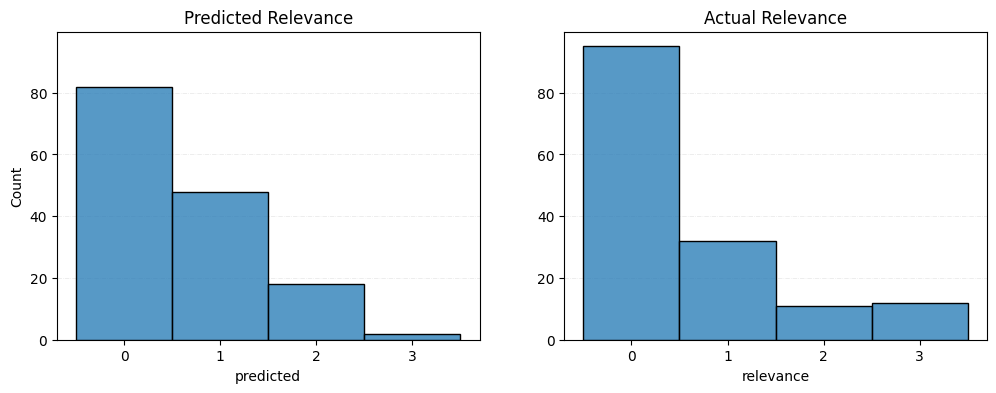

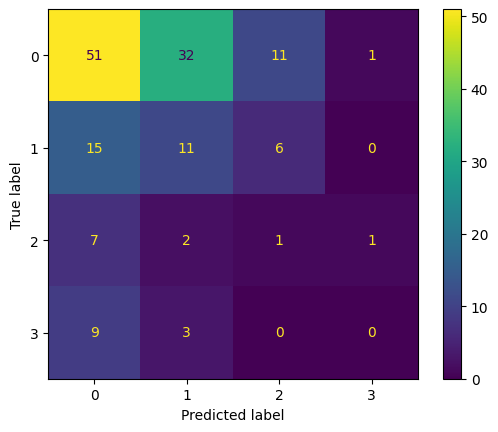



Krippendorff's alpha: -0.05
Spearman's correlation: -0.05
------------------------------ Binary Relevance Eval ------------------------------


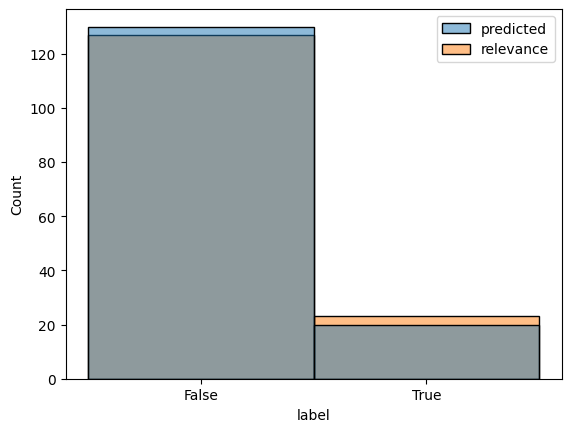

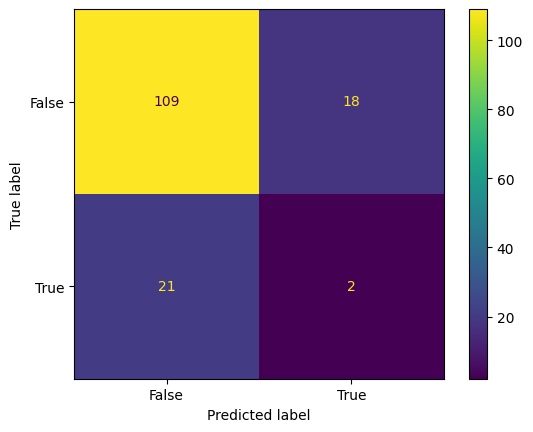



Krippendorff's alpha: -0.06


In [ ]:
trec_eval_df_3 = evaluate_relevance_predictions(
    trec_predictions_df_3, trec_qrels_df
).set_index(["query_id", "doc_id"])